In [1]:
#data.raw = read.csv('loan.csv')

In [2]:
#samp = floor(0.2 * nrow(data.raw))
#temp = sample(seq_len(nrow(data.raw)), size = samp)
#data = data.raw[temp, ]

In [3]:
#columns = c("id", "loan_amnt", "addr_state", "term", "int_rate", "installment", 
#  "grade", "emp_length", "home_ownership", "annual_inc", "open_acc", "acc_now_delinq",
#  "loan_status", "pymnt_plan", "purpose", "application_type", "delinq_2yrs", "verification_status")

In [4]:
#data = data[,columns]

In [5]:
#write.csv(data, "loan_fifth.csv")

# Exploring Financial Loans Issued by Lending Club
#### David Ghan

    Table of Contents:
    1. Import Libraries and Clean Data
    2. Data Exploration and Visualization
    3. Hypothesis Testing
    4. Predictive Analysis
    5. Insights and Conclusions
_____

This report will explore Lending Club's loan data from 2007 to 2015. The data consists of details regarding issued loans to individuals as well as the status and history of each loan. Specific columns have been anonymized for privacy reasons. The primary purpose of this report is to identify trends and correlations that might help to understand details about the borrower or loan type that explain the respective loan status.

A loan's status can be one of seven possible things:
1. Current
2. Fully Paid
3. Charged Off
4. Late (16-30 days)
5. Late (31-120 days)
6. Default
7. Does not meet the credit policy. Status:Charged Off
8. Does not meet the credit policy. Status:Fully Paid
9. Issued
10. In Grace Period
11. (Other)

The raw dataset contained 77 features, many of which contained mostly missing values. For the purpose of better exploring the data without requiring an advanced understanding of lending financials, I reduced the features down to 21. 

I will also split the data into "good loans" and "bad loans". Bad loans are those that are late or defaulted among other statuses that represent poor standing with the lender. These statuses for bad loans are:



**bad_loans**:
1. Charged Off
2. Late (16-30 days)
3. Late (31-120 days)
4. Default
5. Does not meet the credit policy. Status:Charged Off



The remaining statuses will be considered "good loans", since these statuses do not signifiy the borrower's inability to make payments:



**good_loans**:
1. Current
2. Fully Paid
3. Does not meet the credit policy. Status:Fully Paid
4. Issued
5. In Grace Period
6. (Other)
 
 
 
This report will primarily focus on the data as it is distributed according to the two classes of "good" vs. "bad". 

## 1. Import Libraries and Clean Data

In [167]:
options(warn=-1)
library(ggplot2)
library(e1071)
library(gridExtra)
library(simpleboot)
library(MASS)
library(caret)
library(mlbench)
library(choroplethr)
library(MLmetrics)


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall



In [209]:
#data = read.csv("loan_data_reduced.csv")
data = read.csv("loan_fifth.csv")
data = data[complete.cases(data), ]

In [210]:
levels(data$loan_status)[levels(data$loan_status)=="Does not meet the credit policy. Status:Charged Off"] <- "Against policy: Charged Off"
levels(data$loan_status)[levels(data$loan_status)=="Does not meet the credit policy. Status:Fully Paid"] <- "Against policy: Fully Paid"

In [211]:
data$id = NULL
data$X = NULL

In [212]:
data$log_inc = log(data$annual_inc)
data$annual_inc = NULL

In [213]:
nums = sapply(data, is.numeric)
data[, nums] = lapply(data[, nums], scale)

In [214]:
data$bad_status = 0
data$bad_status[data$loan_status == c('Default', 'Charged Off', 'Against policy: Fully Paid')] = 1
data$bad_status = as.numeric(data$bad_status)

In [215]:
good_loan = subset(data, loan_status!=c('Default', 'Charged Off', 'Against policy: Charged Off'))
bad_loan = subset(data, loan_status==c('Default', 'Charged Off', 'Against policy: Charged Off'))

I fixed the numeric columns to be scaled, removed any zero values in income (there were two observations) so that I could log transform and scale, and I group bad loans and good loans into one-hot encoding columns. Now that I have cleaned the dataset and scaled the numeric values, we can start exploring and see what kind of conclusions we can draw from our variables and observations.

In [216]:
summary(data)

     loan_amnt.V1       addr_state            term            int_rate.V1    
 Min.   :-1.6860894   CA     :26156    36 months:124098   Min.   :-1.805135  
 1st Qu.:-0.7997457   NY     :14850    60 months: 53373   1st Qu.:-0.740789  
 Median :-0.2088499   TX     :14256                       Median :-0.057055  
 Mean   : 0.0000000   FL     :12164                       Mean   : 0.000000  
 3rd Qu.: 0.6184043   IL     : 6961                       3rd Qu.: 0.674541  
 Max.   : 2.3910917   NJ     : 6675                       Max.   : 3.589526  
                      (Other):96409                                          
   installment.V1    grade         emp_length     home_ownership 
 Min.   :-1.718365   A:29907   10+ years:58438   ANY     :    2  
 1st Qu.:-0.720916   B:50693   2 years  :15691   MORTGAGE:88240  
 Median :-0.221702   C:49220   < 1 year :14251   NONE    :    7  
 Mean   : 0.000000   D:27780   3 years  :13932   OTHER   :   36  
 3rd Qu.: 0.558663   E:14153   1 year   :11599

## 2. Data Exploration and Visualization

[1] "Proportion of data considered bad loans:  1.75 %"

[1] "Proportion of data considered good loans:  98.25 %"

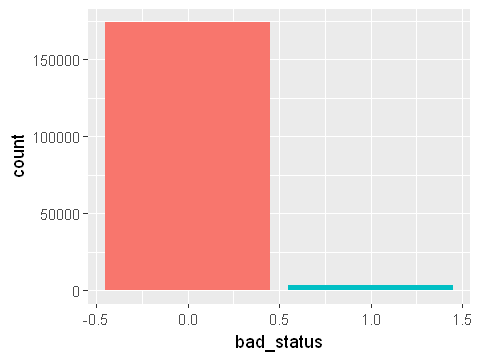

In [249]:
options(repr.plot.width=4, repr.plot.height=3)
ggplot(data, aes(x=bad_status))+geom_bar(stat = "count", aes(fill=factor(bad_status)), show.legend=F)
paste("Proportion of data considered bad loans: ", round(nrow(bad_loan)/nrow(data)*100, 2),"%")
paste("Proportion of data considered good loans: ", round(nrow(good_loan)/nrow(data)*100, 2),"%")

Our labels are unbalanced, which is not much of a surprise. Understanding this will help to determine which metric we will use when applying our predictive analysis to the dataset. We will have to avoid accuracy, because if we assume all loans are good and do not bother with any predictive algorithms, our simple model will still receive an accuracy score of around 98%.

Now let's explore our features and how they relate to our labels.

### Correlation Plot

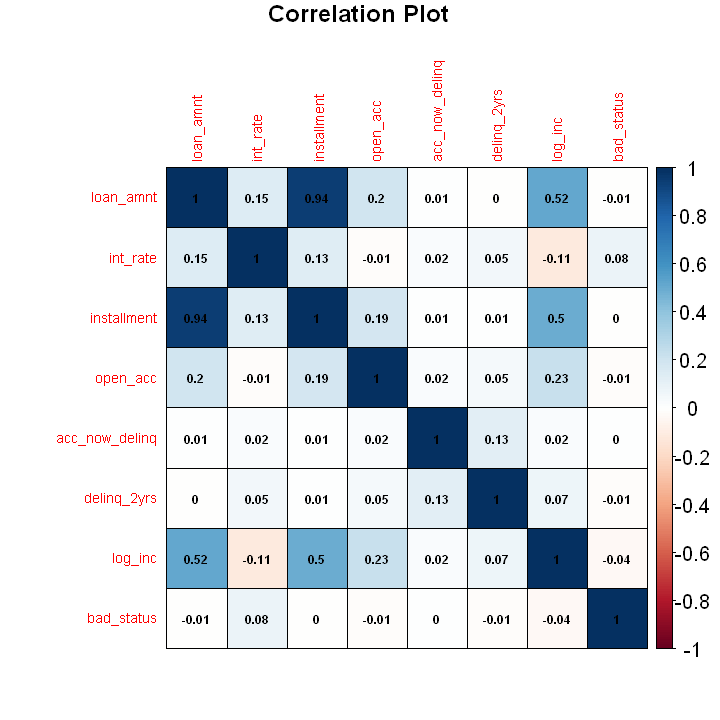

In [225]:
library(corrplot)
options(repr.plot.width=6, repr.plot.height=6)
corrplot(cor(data[, nums]), method='color', 
         outline = TRUE, addCoef.col = 'black', 
         number.digits = 2, number.cex = 0.60, tl.cex = 0.7, cl.cex = 1, title='Correlation Plot', mar=c(0,0,1,0))

A few observations from our correlation plot:
1. Log Income is slightly positively correlated to the loan amount.
2. Installments and loan amount are strongly correlated.

This doesn't reveal much about how are features interact with each other, so next we will dive deeper into our data.

### Purpose of Loan

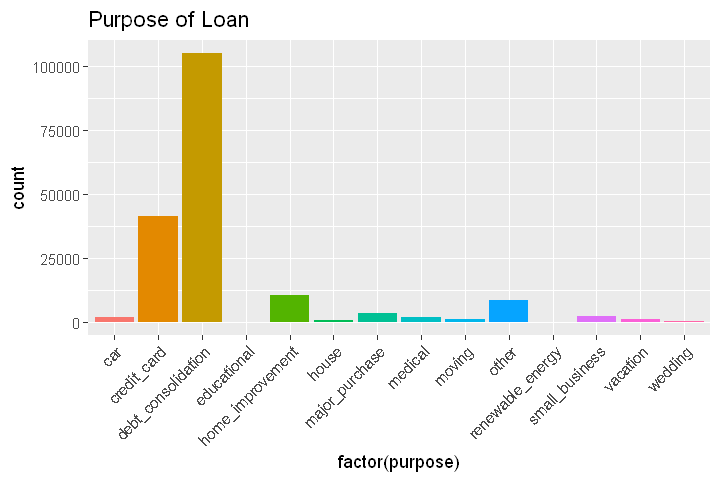

In [227]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data, aes(factor(purpose)))+
geom_bar(stat='count', aes(fill=purpose), show.legend=F)+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle("Purpose of Loan")

Let's start with why the loans are being taken out. Looks largely to be for consolidating other loans and paying off credit card debt. The next most common purpose is for home improvement reasons.

### Delinquent Accounts

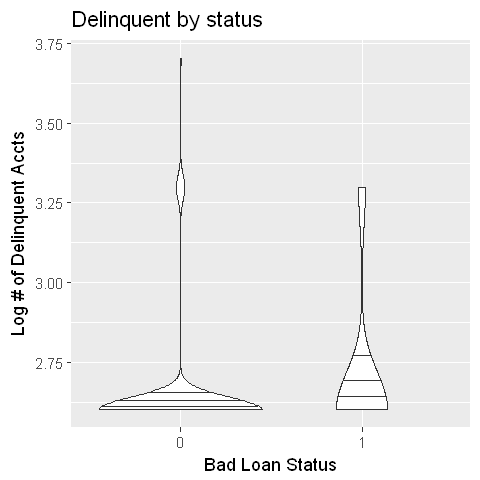

In [245]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(data, aes(factor(bad_status), log(acc_now_delinq)))+
geom_violin(trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75))+
ggtitle("Delinquent by status")+
ylab("Log # of Delinquent Accts")+
xlab("Bad Loan Status")

Bad status loans tend to have more delinquent accounts than those loans that are in good status.There are some outliers for the good status loans, but the quartiles demonstrate the number of delinquent accounts is below those with bad statuses.

### Loan Amount

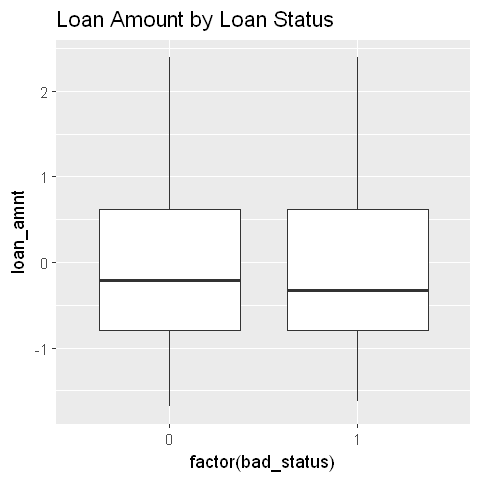

In [244]:
ggplot(data, aes(factor(bad_status), loan_amnt))+
geom_boxplot(aes())+
ggtitle("Loan Amount by Loan Status")

Our boxplot and histogram seem to tell us taht the distribution of loan amounts for each loan status are similar, but we will  confirm this when we test the significance in the next section.

### Logarithmic Annual Income

I took the logarithmic scale of the annual_inc to help us get a more normalized distribution (especially since there are a few outliers).

[1] "Summary of Bad Loans"


       V1         
 Min.   :-3.8634  
 1st Qu.:-0.9079  
 Median :-0.2702  
 Mean   :-0.2661  
 3rd Qu.: 0.3579  
 Max.   : 4.9937  

[1] "Summary of Good Loans"


       V1           
 Min.   :-5.472168  
 1st Qu.:-0.667907  
 Median : 0.012336  
 Mean   : 0.004749  
 3rd Qu.: 0.629170  
 Max.   : 9.249872  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


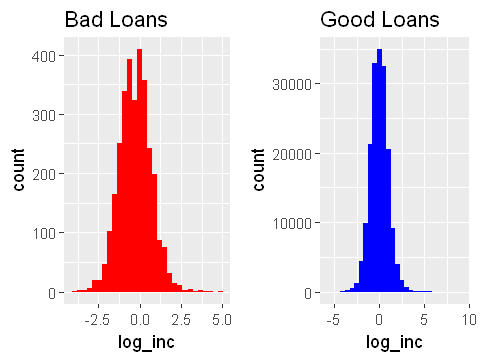

In [62]:
print("Summary of Bad Loans")
summary(bad_loan$log_inc)
print("Summary of Good Loans")
summary(good_loan$log_inc)
a = ggplot(bad_loan, aes(log_inc)) + 
geom_histogram(fill = "red") +
ggtitle("Bad Loans")
b = ggplot(good_loan, aes(log_inc)) + 
geom_histogram(fill = "blue")+
ggtitle("Good Loans")
grid.arrange(a, b, ncol=2)

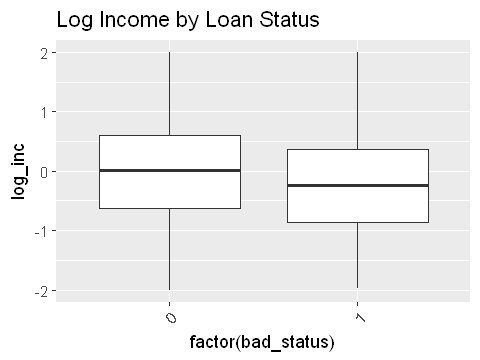

In [64]:
ggplot(data, aes(factor(bad_status), log_inc))+
geom_boxplot()+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle("Log Income by Loan Status")+
ylim(-2, 2)

Our log annual income tends to be lower for bad loans when looking at our box plot and summary statistics.

### Interest Rate

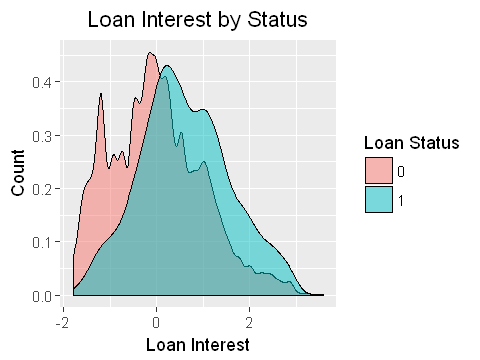

In [65]:
ggplot(data, aes(int_rate, fill = factor(bad_status))) + 
geom_density(alpha = 0.5) +
ylab("Count") +
xlab("Loan Interest") +
guides(fill=guide_legend(title="Loan Status")) +
ggtitle("Loan Interest by Status") +
theme(plot.title = element_text(hjust = 0.5))

Our density histogram seems to demonstrate that the interest rate tends to be higher for bad loans. This is further demonstrated with our boxplot.

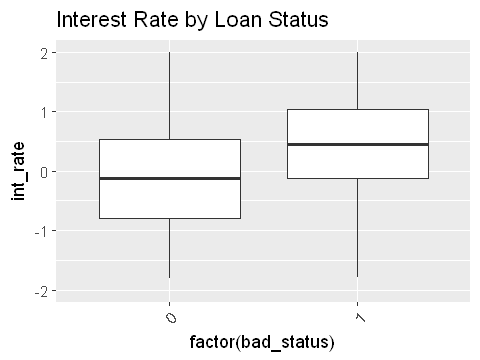

In [66]:
ggplot(data, aes(factor(bad_status), int_rate))+
geom_boxplot()+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle("Interest Rate by Loan Status")+
ylim(-2, 2)

## 3. Hypothesis Testing

### Loan Amount

In [67]:
plot.hist <- function(a, maxs, mins, cols = 'difference of means', nbins = 80, p = 0.05) {
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols), xlab = cols)
  abline(v = mean(a), lwd = 4, col = 'red')
  abline(v = 0, lwd = 4, col = 'blue')
  abline(v = quantile(a, probs = p/2), lty = 3, col = 'red', lwd = 3)  
  abline(v = quantile(a, probs = (1 - p/2)), lty = 3, col = 'red', lwd = 3)
}
plot.diff <- function(a, cols = 'difference of means', nbins = 80, p = 0.05){
  maxs = max(a)
  mins = min(a)
  plot.hist(a, maxs, mins, cols = cols[1])
}
options(repr.plot.width=6, repr.plot.height=4)

In [68]:
two.boot.mean = two.boot(bad_loan$emp_length, good_loan$emp_length, mean, R = 1000)

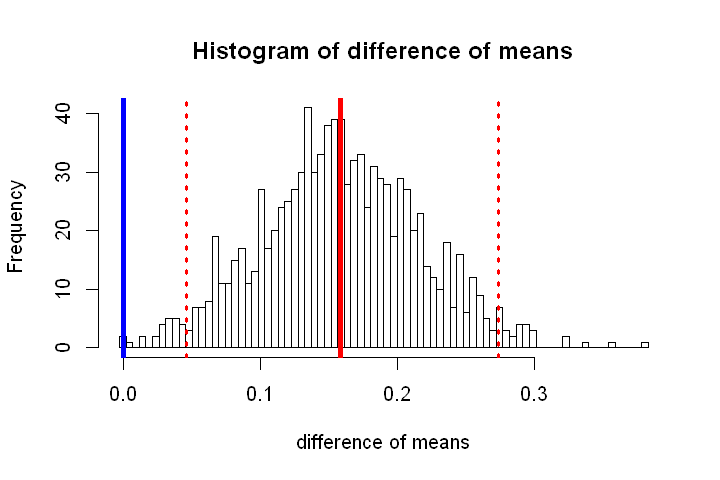

In [69]:
plot.diff(two.boot.mean$t)

Our bootstrap sampling hypothesis test tells us that we **can** reject the null hypothesis that our two datasets are significantly different.

### Length of Employment

In [70]:
#detach("package:dplyr", unload=TRUE)
require(plyr)

Loading required package: plyr


In [71]:
conv_to_prob = function(data, var){
    table = count(data, vars = var)
    return(table)
    }

In [72]:
chi_table = function(data, var){
    table = conv_to_prob(data, var)
    row.names(table) = table[,1]
    n = nrow(table)
    table$expected = sum(table$freq) / (n)
    table$expected_p = table$expected / sum(table$freq)
    table$diff = table$freq - table$expected
    table$sq_diff = table$diff^2
    table$diff_expec = table$sq_diff/table$expected
    table[,1] = NULL
    return(table)
}

In [73]:
good_emp = chi_table(good_loan, "emp_length")
chisq.test(good_emp$freq, p = good_emp$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  good_emp$freq
X-squared = 144310, df = 11, p-value < 2.2e-16


In [74]:
bad_emp = chi_table(bad_loan, "emp_length")
chisq.test(bad_emp$freq, p = bad_emp$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  bad_emp$freq
X-squared = 1663.1, df = 11, p-value < 2.2e-16


### Chi-square test on home ownership

In [80]:
bad_hom = chi_table(bad_loan, "home_ownership")
chisq.test(bad_hom$freq, p = bad_hom$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  bad_hom$freq
X-squared = 2093.6, df = 3, p-value < 2.2e-16


In [81]:
good_hom = chi_table(good_loan, "home_ownership")
chisq.test(good_hom$freq, p = good_hom$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  good_hom$freq
X-squared = 264790, df = 5, p-value < 2.2e-16


The null hypotheses for both the home ownership status and employment status can be rejected. The features seem to carry enough significance for us when talking about loan status.

#### Chi-square test on purpose of loan

In [82]:
bad_purp = chi_table(bad_loan, "purpose")
chisq.test(bad_purp$freq, p = bad_purp$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  bad_purp$freq
X-squared = 14835, df = 13, p-value < 2.2e-16


In [83]:
good_purp = chi_table(good_loan, "purpose")
chisq.test(good_purp$freq, p = good_purp$expected_p, correct = FALSE)


	Chi-squared test for given probabilities

data:  good_purp$freq
X-squared = 825310, df = 13, p-value < 2.2e-16


Looking at the results, we can see that there is significant differences between the good and bad loans according to each of the three categorial variables explored. A significant reason for this is the large amount of observations the dataset has. This allows us to get a larger view of how our features are distributed according to the two target variables of "good" vs. "bad" loans.

### Logarithmic Annual Income

In [85]:
df_aov = aov(log_inc ~ factor(bad_status), data = data)
summary(df_aov)
print(df_aov)

                       Df Sum Sq Mean Sq F value Pr(>F)    
factor(bad_status)      1    228   227.8   228.1 <2e-16 ***
Residuals          177469 177242     1.0                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Call:
   aov(formula = log_inc ~ factor(bad_status), data = data)

Terms:
                factor(bad_status) Residuals
Sum of Squares              227.82 177242.18
Deg. of Freedom                  1    177469

Residual standard error: 0.9993608
Estimated effects may be unbalanced


In [86]:
comp.like = function(p, x){
    l = rep(0, length = length(p))
    sigmaSqr = sd(x)^2
    xBar = mean(x)
    cat(' Mean =', xBar, 'Standard deviation =', sqrt(sigmaSqr), '\n')
    n = length(x)
#    l = sapply(p, function(u) dnorm(u, mean = xBar, sd = sigmaSqr))
    l = sapply(p, function(u) exp(- n* (xBar - u)^2 / (2 * sigmaSqr)))
    l / sum(l) # Normalize and return
}

In [87]:
posterior = function(prior, like){
    post = prior * like  # Compute the product of the probabilities
    post / sum(post) # Normalize and return
}

plot.post = function(prior, like, post, x){
    maxy = max(c(prior, like, post))
    plot(x, like, , lty = 1, ylim = c(0.0, maxy), 
         ylab = 'Density', xlab = 'Parameter value',
         main = 'Density of prior, likelihood, posterior',
         lwd = 2, col = 'green')
    lines(x, prior, lty = 2, lwd = 2, col = 'blue')    
    lines(x, post, lty = 1, lwd = 2, col = 'red')
    legend('topright', c('likelihood', 'prior', 'posterior'), 
    lty=1, col=c('green', 'blue', 'red'), bty='n', cex=1.0)
    
    cat(' Maximum of prior density =', round(x[which.max(prior)], 3), '\n',
        'Maximum likelihood =', round(x[which.max(like)], 3), '\n',
         'MAP =', round(x[which.max(post)], 3))
}

In [88]:
plot.ci = function(p, post, nSamps, qs){
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samps = sample(p, size = nSamps, replace = TRUE, prob = post)
    ci = quantile(samps, probs = qs) # compute the quantiles
    
    ## Plot the density with the credible interval
    interval = qs[2] - qs[1]
    title = paste('Posterior density with', interval, 'credible interval')
    plot(p, post, , typ = 'l', ylab = 'Density', xlab = 'Parameter value',
         main = title, lwd = 2, col = 'blue')
    abline(v = ci[1], col = 'red', lty = 2, lwd = 2)
    abline(v = ci[2], col = 'red', lty = 2, lwd = 2)
    cat('The', interval, 'Credible interval is', 
        round(ci[1], 2), 'to', round(ci[2], 2))
    }

In [89]:
N = 100
p = seq(min(data$log_inc), max(data$log_inc), length=N)
bad_loan$log_inc = sort(bad_loan$log_inc, decreasing = FALSE)
good_loan$log_inc = sort(good_loan$log_inc, decreasing = FALSE)
mean_income = round(mean(data$log_inc))
pp = dnorm(p, mean = mean_income, sd = sd(data$log_inc)) ## start with a fairly broad prior
pp = pp / sum(pp)

 Mean = -0.2660901 Standard deviation = 0.966504 
 Mean = 0.004749237 Standard deviation = 0.9999474 
The 0.95 Credible interval is -0.27 to -0.27

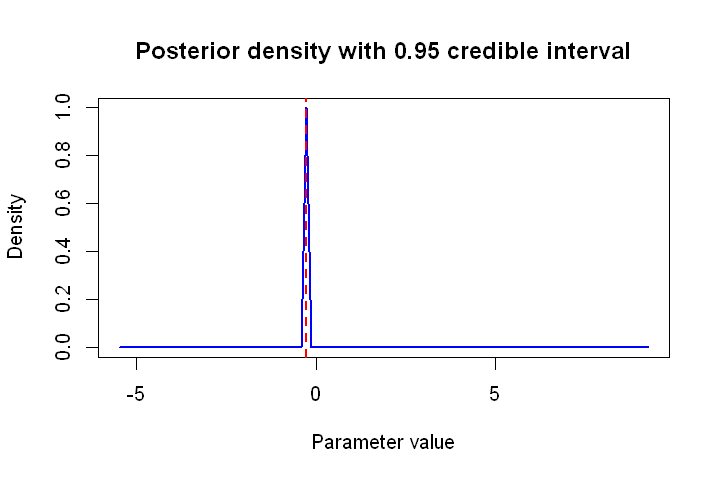

The 0.95 Credible interval is 0.03 to 0.03

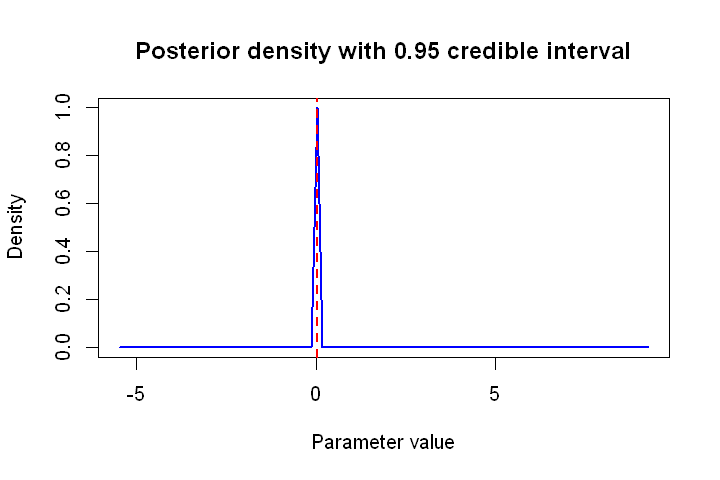

In [90]:
like.bad = comp.like(p, bad_loan$log_inc)
post.bad = posterior(pp, like.bad)
like.good = comp.like(p, good_loan$log_inc)
post.good = posterior(pp, like.good)
nSamps = 100
qs = c(0.025, 0.975)
plot.ci(p, post.bad, nSamps, qs)
plot.ci(p, post.good, nSamps, qs)

The Baysian model of the log income tells us to reject the null hypothesis that the good and bad loans carry similar distributions according to income. Our visualization before we conducted our hypothesis test reveals that the loan amount of bad loans tends to be smaller than loans in good standing.

### Loan status by state

## 4. Predictive Analysis

My predictive model will be a Naive Bayes classifier and will be measured by an F1 score, which takes both the precision and recall of my confusion matrix. I will compare a base model, which will be the classifier using all features, with a step-wise AIC optimized set a features. First, I will separate the data into training and test sets.

In [92]:
set.seed(1987)
col.rmv = names(data) %in% c('loan_status', 'bad_loan', 'good_loan')
temp = data[!col.rmv]
smp_size = floor(0.75 * nrow(temp))
train_ind = sample(seq_len(nrow(temp)), size = smp_size)

train = temp[train_ind, ]
test = temp[-train_ind, ]
test_x = subset(test, select=-bad_status)
test_y = factor(test$bad_status)

In [93]:
model = glm(bad_status ~., data=train, family='binomial')

In [94]:
summary(model)


Call:
glm(formula = bad_status ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1209  -0.2104  -0.1616  -0.1204   3.3982  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -1.545e+01  1.696e+03  -0.009 0.992730    
loan_amnt                           5.875e-02  1.536e-01   0.382 0.702189    
addr_stateAL                        2.185e-01  4.483e-01   0.487 0.625959    
addr_stateAR                        4.719e-02  4.789e-01   0.099 0.921492    
addr_stateAZ                       -1.556e-01  4.401e-01  -0.354 0.723708    
addr_stateCA                        1.168e-01  4.179e-01   0.280 0.779807    
addr_stateCO                        8.292e-02  4.380e-01   0.189 0.849851    
addr_stateCT                        1.246e-01  4.463e-01   0.279 0.780117    
addr_stateDC                       -1.834e+00  1.086e+00  -1.690 0.091116 .  
addr_stateDE       

In [95]:
AIC_test = stepAIC(model)

Start:  AIC=22296.34
bad_status ~ loan_amnt + addr_state + term + int_rate + installment + 
    grade + emp_length + home_ownership + annual_inc + open_acc + 
    acc_now_delinq + pymnt_plan + purpose + application_type + 
    delinq_2yrs + verification_status + log_inc

                      Df Deviance   AIC
- addr_state          49    22187 22285
- installment          1    22100 22294
- pymnt_plan           1    22100 22294
- acc_now_delinq       1    22101 22295
- loan_amnt            1    22101 22295
- annual_inc           1    22101 22295
- home_ownership       5    22110 22296
<none>                      22100 22296
- term                 1    22103 22297
- open_acc             1    22103 22297
- application_type     1    22104 22298
- log_inc              1    22111 22305
- emp_length          11    22133 22307
- delinq_2yrs          1    22116 22310
- verification_status  2    22119 22311
- purpose             13    22173 22343
- grade                6    22306 22490
- int_ra

The step-wise AIC function came up with the follow features as significant to the model:

1. loan_amnt
2. term
3. int_rate
4. grade
5. emp_length
6. home_ownership
7. open_acc
8. purpose
9. application_type
10. delinq_2yrs
11. verification_status
12. log_inc

We removed eight other features in the process. Next let's look at our baseline model (with all features) and our step-wise AIC optimized model. I will also manually choose features for a third model to compar with our stepwise model.

In [110]:
base.model = naiveBayes(factor(bad_status) ~ ., data=train)

In [111]:
opt.model = naiveBayes(factor(bad_status) ~ loan_amnt + term + int_rate + grade + emp_length + 
    home_ownership + open_acc + purpose + application_type + 
    delinq_2yrs + verification_status + log_inc, data=train)

In [ ]:
man.model = naiveBayes(factor(bad_status) ~ loan_amnt + int_rate + grade + emp_length + 
    home_ownership + purpose + log_inc, data=train)

In [112]:
base.pred = predict(base.model, test_x)
opt.pred = predict(opt.model, test_x)
man.pred = predict(man.model, test_x)

In [263]:
paste("Base Model Confusion Matrix")
confusionMatrix(base.pred, test_y, positive = '1')

[1] "Base Model Confusion Matrix"

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 43465   824
         1    72     7
                                          
               Accuracy : 0.9798          
                 95% CI : (0.9785, 0.9811)
    No Information Rate : 0.9813          
    P-Value [Acc > NIR] : 0.9884          
                                          
                  Kappa : 0.0122          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0084236       
            Specificity : 0.9983462       
         Pos Pred Value : 0.0886076       
         Neg Pred Value : 0.9813949       
             Prevalence : 0.0187297       
         Detection Rate : 0.0001578       
   Detection Prevalence : 0.0017806       
      Balanced Accuracy : 0.5033849       
                                          
       'Positive' Class : 1               
                                          

In [264]:
paste('AIC-Optimized Model Confusion Matrix')
confusionMatrix(opt.pred, factor(test_y), positive = '1')

[1] "AIC-Optimized Model Confusion Matrix"

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 43506   828
         1    31     3
                                          
               Accuracy : 0.9806          
                 95% CI : (0.9793, 0.9819)
    No Information Rate : 0.9813          
    P-Value [Acc > NIR] : 0.8409          
                                          
                  Kappa : 0.0055          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 3.610e-03       
            Specificity : 9.993e-01       
         Pos Pred Value : 8.824e-02       
         Neg Pred Value : 9.813e-01       
             Prevalence : 1.873e-02       
         Detection Rate : 6.762e-05       
   Detection Prevalence : 7.663e-04       
      Balanced Accuracy : 5.014e-01       
                                          
       'Positive' Class : 1               
                                          

In [265]:
confusionMatrix(man.pred, test_y, positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 43532   830
         1     5     1
                                          
               Accuracy : 0.9812          
                 95% CI : (0.9799, 0.9824)
    No Information Rate : 0.9813          
    P-Value [Acc > NIR] : 0.5648          
                                          
                  Kappa : 0.0021          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.203e-03       
            Specificity : 9.999e-01       
         Pos Pred Value : 1.667e-01       
         Neg Pred Value : 9.813e-01       
             Prevalence : 1.873e-02       
         Detection Rate : 2.254e-05       
   Detection Prevalence : 1.352e-04       
      Balanced Accuracy : 5.005e-01       
                                          
       'Positive' Class : 1               
                                          

In [260]:
paste('Base Model F1 Score')
F1_Score(test_y, base.pred, positive='1')
paste('AIC-Optimized Model F1 Score')
F1_Score(test_y, opt.pred, positive='1')
paste('Manual Model F1 Score')
F1_Score(test_y, man.pred, positive='1')

[1] "Base Model F1 Score"

[1] 0.01538462

[1] "AIC-Optimized Model F1 Score"

[1] 0.006936416

[1] "Manual Model F1 Score"

[1] 0.002389486

Our AIC-optimized model and manual model perform worse than our base line model, which took all features into account during the training process. It looks like our step-wise AIC removed the significant features. It is a little misleading to see the accuracy score increase with the optimized model, but that does not mean it is a better model. Our F1 score reveals that the baseline model is the preferred model of the three.

## Insights and Conclusions

### The features

After exploring are features and comparing the two statuses of loans (good and bad), we can build a functional model that successfully trains on our data with the optimal features to predict loans that will be in bad statuses.

*Data exploration*

Some key insights from our data analysis includes:
1. There are significant differences between good and bad loans according to home ownership and annual income.
2. Most loans taken out are for loan consolidation and credit card debt payement.
3. Loans with bad statuses are more likely to be owned by a lender with other delinquent loan accounts than those loans with good statuses.
4. Interest rates are usually higher for bad loans than good loans.

*Predictive Model*

Using step-wise AIC,our optimal Naive Bayes Classifier performed better according to accuracy but worse according to the preferred metric, F1 score. A better model would require further examination of our features and, perhaps, some feature transformations.